# HEP-like 1D mixture with norm nuissances

In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# easier access to tensorflow distributions
ds = tf.contrib.distributions

sess = tf.Session()

## unbinned likelihood extended

In [2]:
# use (None,) shape so a vector of g can be used
s = tf.placeholder_with_default([200.], shape=(None,))
# parameters
mu_init = tf.placeholder_with_default([1.0], shape=(None,))
nuis_pars_init = [tf.placeholder_with_default([2500.0], shape=(None,), name="b_0"),
             tf.placeholder_with_default([2500.0], shape=(None,), name="b_1")]
par_list = [mu_init] + nuis_pars_init

# create a flat node with all pars is in the graph,
# useful later for autodiff
all_pars = tf.stack(par_list, axis=1)
all_pars_flatten = tf.reshape(all_pars, [tf.size(all_pars)])
all_pars_again = tf.reshape(all_pars_flatten, tf.shape(all_pars))
# a similar thing but now with only nuissances
nuis_pars_t = all_pars_again[:,1:] 
nuis_pars_flatten = tf.reshape(nuis_pars_t, [tf.size(nuis_pars_t)])
nuis_pars_again = tf.reshape(nuis_pars_flatten, tf.shape(nuis_pars_t))
mu = all_pars_again[:,0]
nuis_pars =  tf.unstack(nuis_pars_again,axis=1)

# to simplify broadcasting in case of multiple mu input
def repeat_mu(x):
    return tf.tile(x, tf.shape(mu))

# nuissance constraints (they are TF distributions so we can sample)            
nuis_cons = [ds.Normal(loc=repeat_mu([2500.0]), scale=repeat_mu([200.])),
             ds.Normal(loc=repeat_mu([2500.0]), scale=repeat_mu([200.]))]
             
components = [
    ds.Normal(loc=repeat_mu([-2.0]), scale=repeat_mu([0.75])), # c0 (background)
    ds.Normal(loc=repeat_mu([0.0]), scale=repeat_mu([2.0])), # c1 (background)
    ds.Normal(loc=repeat_mu([1.0]), scale=repeat_mu([0.5]))  # c2 (bump/signal)
]

tot_exp = mu*s+sum(nuis_pars)
probs = tf.transpose(tf.stack([nuis_pars[0]/tot_exp,
                               nuis_pars[1]/tot_exp,
                               s*mu/tot_exp]))
cat = ds.Categorical(probs=probs)
# mix is the mixture distribution (mu/b1/b2 can be modified)
mix = ds.Mixture(components=components, cat=cat)

In [3]:
# extended likelihood component
ext_term = ds.Poisson(tot_exp[:,tf.newaxis])

In [4]:
# get toy data
random_seed = 47
nuis_true = [nuis_cons[0].sample(seed=random_seed),
             nuis_cons[0].sample(seed=random_seed+2) ]
n_true = ds.Poisson(mu*s+sum(nuis_true)).sample(tf.shape(mu_init)[0],seed=random_seed)

In [5]:
mu_true_arr, nuis_true_arr, n_true_arr = sess.run([mu, nuis_true, n_true], feed_dict={mu : [1.]})

In [6]:
n = tf.placeholder_with_default([5000],shape=(None,))
data = mix.sample(n)
data_arr = sess.run(data,
                    feed_dict={mu: mu_true_arr,
                               nuis_pars[0] : nuis_true_arr[0],
                               nuis_pars[1] : nuis_true_arr[1],
                               n : n_true_arr[0]})

data_arr

array([[2.5819726 ],
       [0.1456402 ],
       [0.1617055 ],
       ...,
       [1.8287393 ],
       [0.60233194],
       [0.9106905 ]], dtype=float32)

In [7]:
x_values = tf.linspace(-5.,5.,num=1000)[:,tf.newaxis]
x_values_arr, probs_arr = sess.run([x_values, mix.prob(x_values)],
                                   feed_dict={mu : [0.0, 1.]})

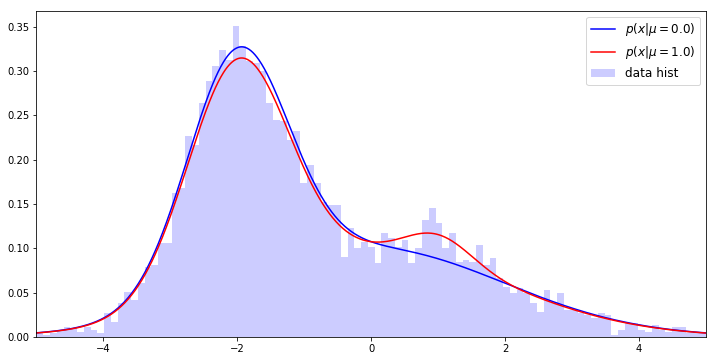

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(x_values_arr, probs_arr[:,0], label=r"$p(x|\mu=0.0)$", color="b")
ax.plot(x_values_arr, probs_arr[:,1], label=r"$p(x|\mu=1.0)$", color="r")
bins =  np.linspace(-5.,5.,100,endpoint=True, dtype=np.float32)
ax.hist(data_arr, bins=bins, normed=True, label="data hist",
        alpha=0.2, color="b")
ax.set_xlim(-5.,5.)
ax.legend(loc="best", prop={'size' : 12})

fig;

In [17]:
# likelihood (no nuissances - not extended)
n_data = tf.convert_to_tensor([data_arr.shape[0]], dtype=tf.float32)
nll_naive = - tf.reduce_sum(mix.log_prob(data_arr),axis=0)
# extended likelihood
ext_nll_data = tf.reduce_sum(ext_term.log_prob([n_data]),axis=1)
nll_ext = nll_naive - ext_nll_data
# add constraint terms
cons_nll_pars = [c_dist.log_prob(c_val) for c_dist, c_val in zip(nuis_cons,nuis_pars)]
nll_ext_cons = nll_ext - sum(cons_nll_pars)

In [14]:
# ML all parameters free
nll_ext_cons_grad = tf.gradients(nll_ext_cons, all_pars_flatten)
# this could be optimzed used a static number of pars
nll_ext_cons_hess = tf.hessians(nll_ext_cons, all_pars_flatten)
# could directly invert the block
nll_ext_cons_cov = tf.matrix_inverse(nll_ext_cons_hess)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
# naive second order Newton optimization method
# with a simplistic max gradient max termination
pars_update =  np.array([1.1,2500.,2500.])

abs_grad_max = 100.
while True:

    grad, cov, nll = sess.run([nll_ext_cons_grad[0],
                                nll_ext_cons_cov[0],
                                nll_ext_cons],
                                feed_dict={mu_init : pars_update[0:1],
                                     nuis_pars_init[0] : pars_update[1:2],
                                     nuis_pars_init[1] : pars_update[2:3]})
    print("nll {} - pars {} ".format(nll, pars_update))
    abs_grad_max = np.max(np.abs(grad))
    if abs_grad_max > 1.e-4:
        pars_update -= cov.dot(grad)
    else:
        break
    
ml_pars = pars_update

nll [10073.243] - pars [1.1e+00 2.5e+03 2.5e+03] 
nll [10071.189] - pars [1.12855273e+00 2.62051314e+03 2.43429459e+03] 
nll [10071.1875] - pars [1.12865658e+00 2.62325097e+03 2.43489558e+03] 


In [20]:
print("maximum likelihood estimations of pars {}".format(ml_pars))
print("uncertainties from inverse hessian {}".format(np.sqrt(np.diag(cov))))

maximum likelihood estimations of pars [1.12865658e+00 2.62325097e+03 2.43489558e+03]
uncertainties from inverse hessian [ 0.20149192 62.8263     79.49422   ]


In [18]:
mu_arr = np.linspace(0.2,1.7,101, endpoint=True)
input_dict = {mu_init : mu_arr,
               nuis_pars_init[0] : ml_pars[1]*np.ones_like(mu_arr),
               nuis_pars_init[1] : ml_pars[2]*np.ones_like(mu_arr)}
nll_arr = sess.run(nll_naive, feed_dict=input_dict)
nll_ext_arr = sess.run(nll_ext,feed_dict=input_dict)
# variation with mu should be the same than nll_ext (only constant term)
nll_ext_cons_arr = sess.run(nll_ext_cons,feed_dict=input_dict)

In [19]:
# ML only nuissances free
nll_ext_cons_sub_grad = tf.gradients(nll_ext_cons, nuis_pars_flatten)
# this could be optimized (only block diagonal non-zero)
nll_ext_cons_sub_hess = tf.hessians(nll_ext_cons, nuis_pars_flatten)
# could directly invert the subblocks (much faster)
nll_ext_cons_sub_cov = tf.matrix_inverse(nll_ext_cons_sub_hess)

In [21]:
# naive second order Newton optimization method
# with a simplistic gradient max termination
# now for profiled likelihood
mu_scan = np.linspace(0.2,1.7,101)
pars_update_prof = np.repeat(ml_pars[np.newaxis],mu_scan.shape[0],axis=0)
pars_update_prof[:,0] = mu_scan

abs_grad_max = 100.
while True:

    grad_prof, cov_prof, nll_prof = sess.run([nll_ext_cons_sub_grad[0],
                                nll_ext_cons_sub_cov[0],
                                nll_ext_cons],
                                feed_dict={mu_init : pars_update_prof[:,0],
                                     nuis_pars_init[0] : pars_update_prof[:,1],
                                     nuis_pars_init[1] : pars_update_prof[:,2]})
    abs_grad_max = np.max(np.abs(grad_prof))
    print("iteration , max abs grad {}".format(abs_grad_max))
    pars_update_prof_flat = pars_update_prof[:,1:].flat
    if abs_grad_max > 1.e-4:
        pars_update_prof_flat[:] = pars_update_prof_flat[:] - cov_prof.dot(grad_prof)
    else:
        break
    
ml_pars_prof = pars_update_prof

iteration , max abs grad 0.07179400324821472
iteration , max abs grad 0.005258482880890369
iteration , max abs grad 3.172573633491993e-05


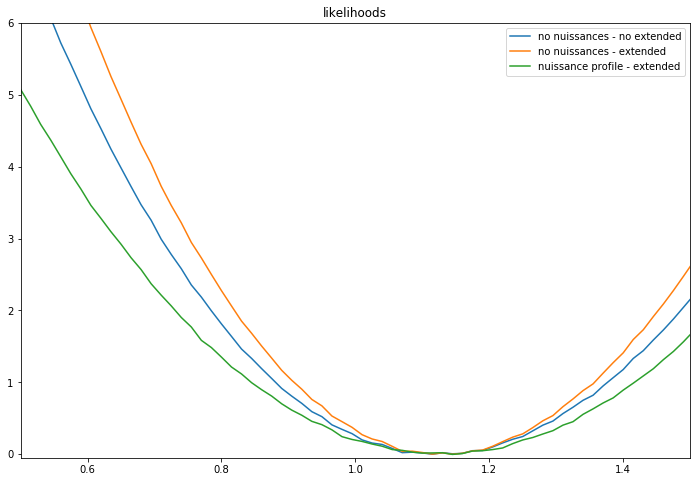

In [23]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(mu_arr, nll_arr-nll_arr.min(), label="no nuissances - no extended")
ax.plot(mu_arr, nll_ext_arr-nll_ext_arr.min(),  label="no nuissances - extended")
ax.plot(mu_scan, nll_prof-nll.min(), label="nuissance profile - extended")

ax.set_title("likelihoods")
ax.set_xlim(0.5,1.5)
ax.set_ylim(-0.05,6.0)

ax.legend()
fig;